<a href="https://colab.research.google.com/github/ilmechaJu/keras/blob/main/ch03_%EC%BC%80%EB%9D%BC%EC%8A%A4_%EC%9E%90%EB%8F%99%EC%B0%A8_%EC%97%B0%EB%B9%84_%EC%98%88%EC%B8%A1_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 케라스 자동차 연비 예측 모델

- Source : https://www.tensorflow.org/tutorials/keras/regression

### modules import

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import get_file, plot_model

In [ ]:
sns.set(style='white')
plt.style.use('seaborn-white')

### 데이터 로드

In [ ]:
dataset_path = get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path ##경로확인

32768/30286 [================================] - 0s 2us/step


'/root/.keras/datasets/auto-mpg.data'

In [ ]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration','Model Year', 'Origin']

### 데이터 확인

In [ ]:
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values='?', comment='\t',
                          sep=" ",skipinitialspace = True)

dataset =  raw_dataset.copy()
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


### 데이터 전처리


- 해당 데이터는 일부 데이터가 누락되어 있음

In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

- 누락된 행 삭제

In [ ]:
dataset = dataset.dropna()

- "Origin" 범주형 데이터
  - 원-핫 인코딩(one-hot encoding) 진행

In [ ]:
dataset["Origin"].unique() #범주형 1,3,2

array([1, 3, 2])

In [ ]:
origin = dataset.pop('Origin')

In [ ]:
dataset['USA'] = (origin==1)*1.0
dataset['Europe'] = (origin==2)*1.0
dataset['Japen'] = (origin==3)*1.0
dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japen
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0


#### 검증 데이터셋 생성

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state = 0)
test_dataset = dataset.drop(train_dataset.index)

#### 데이터 조사

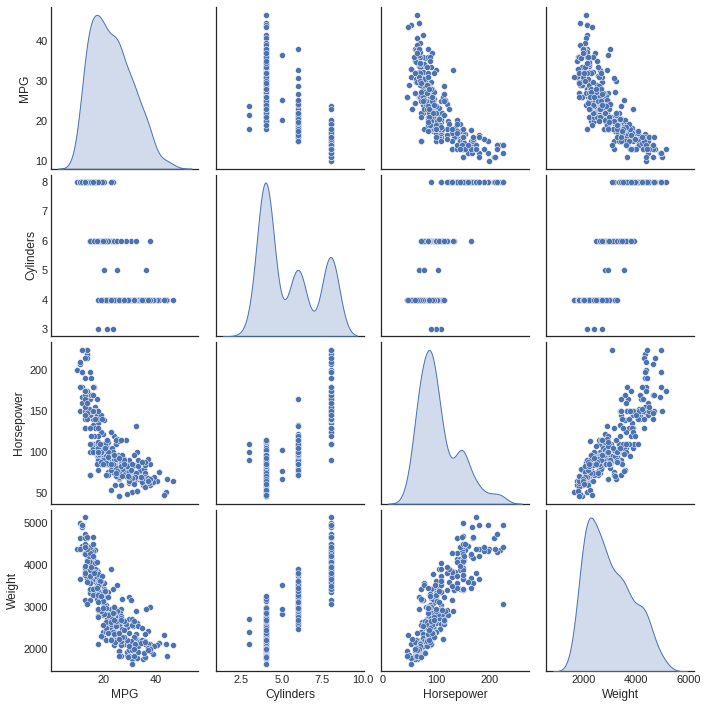

In [ ]:
sns.pairplot(train_dataset[["MPG","Cylinders","Horsepower","Weight"]],diag_kind="kde")

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japen,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


#### 데이터의 특성과 레이블 분리

In [ ]:
train_lables = train_dataset.pop('MPG')
test_lables = test_dataset.pop('MPG') 

KeyError: ignored

#### 데이터 정규화

In [ ]:
def normalization(x):
  return (x- train_stats['mean']) / train_stats['std']

normed_train_data = normalization(train_dataset) 
normed_test_data = normalization(test_dataset)

### 모델 구성

In [ ]:
def build_model():
  input = Input(shape=(len(train_dataset.keys())), name = 'input')
  hidden1 = Dense(64, activation = 'relu', name = 'hidden1') (input)
  hidden2 =Dense(64, activation = 'relu', name = 'hidden2')(hidden1)
  output = Dense(1, name = 'output')(hidden2)

  model = Model(inputs=[input], outputs=output)
  model.compile(loss = 'mse',
                optimizer=RMSprop(0.001),
                metrics = ['mae','mse'])
  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()     

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 9)]               0         
_________________________________________________________________
hidden1 (Dense)              (None, 64)                640       
_________________________________________________________________
hidden2 (Dense)              (None, 64)                4160      
_________________________________________________________________
output (Dense)               (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


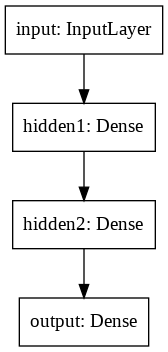

In [ ]:
plot_model(model)

### 샘플 데이터 확인

In [ ]:
sample_batch = normed_train_data[:10]
sample_result = model.predict(sample_batch)
sample_batch

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japen
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852
257,0.307270,0.351586,-0.390312,0.260397,0.588250,0.571849,0.774676,-0.465148,-0.495225
310,-0.869348,-1.019044,-1.177792,-1.211344,1.161885,1.115971,-1.286751,-0.465148,2.012852
328,-0.869348,-0.472709,-0.994047,0.307796,2.237451,1.115971,-1.286751,2.143005,-0.495225
125,0.307270,0.025702,-0.259066,0.132419,0.337285,-0.516397,0.774676,-0.465148,-0.495225
108,-0.869348,-0.942365,-0.442811,-0.842816,1.233589,-0.788458,-1.286751,-0.465148,2.012852


### 모델 학습

In [ ]:
epochs = 1000
history = model.fit(normed_train_data, train_labels, epochs=epochs, validation_split = 0.2)

NameError: ignored

### 모델 학습 시각화

### EarlyStopping을 이용한 규제화

### 모델 평가

### 학습된 모델을 통한 예측